# Approach 1

## Part 1: Lane Detection on Front-View Image

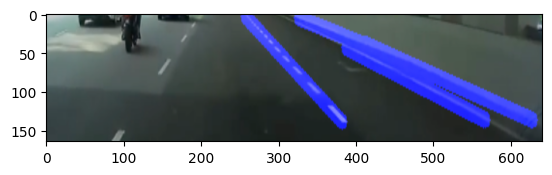

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    return cv2.Canny(blur, 50, 150)

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None and len(lines) > 0:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

def select_points(image, points_num=4):
    points = []
    temp_image = image.copy()  # Use a temporary image to show updates
    def click_event(event, x, y, flags, params):
        if event == cv2.EVENT_LBUTTONDOWN:
            cv2.circle(temp_image, (x, y), 5, (0, 0, 255), -1)
            points.append((x, y))
            if len(points) > 1:
                # Draw line to the previous point
                cv2.line(temp_image, points[-2], points[-1], (0, 255, 0), 2)
            if len(points) == points_num:
                # Complete the region by connecting the last and first point
                cv2.line(temp_image, points[-1], points[0], (0, 255, 0), 2)
            cv2.imshow("Select ROI", temp_image)
    cv2.imshow("Select ROI", temp_image)
    cv2.setMouseCallback("Select ROI", click_event)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return np.array(points, dtype=np.int32)

def detect_lanes(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return None
    points = select_points(image)
    roi_image = image[np.min(points[:, 1]):np.max(points[:, 1]), np.min(points[:, 0]):np.max(points[:, 0])]
    canny_image = canny(roi_image)
    lines = cv2.HoughLinesP(canny_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=50)
    
    if lines is not None:
        line_image = display_lines(roi_image, lines)
        combo_image = cv2.addWeighted(roi_image, 0.8, line_image, 1, 1)
        return combo_image
    else:
        print("No lines detected")
        return roi_image

# Load and process the image
result = detect_lanes('resembler5.jpeg')
if result is not None:
    original_height, original_width = result.shape[:2]
    new_width = int(original_width * 1.25)
    new_height = int(original_height * 2)
    resized_result = cv2.resize(result, (new_width, new_height))
    plt.imshow(cv2.cvtColor(resized_result, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Failed to process image")

## Part 2: Perspective Transformation (Front to Top View)

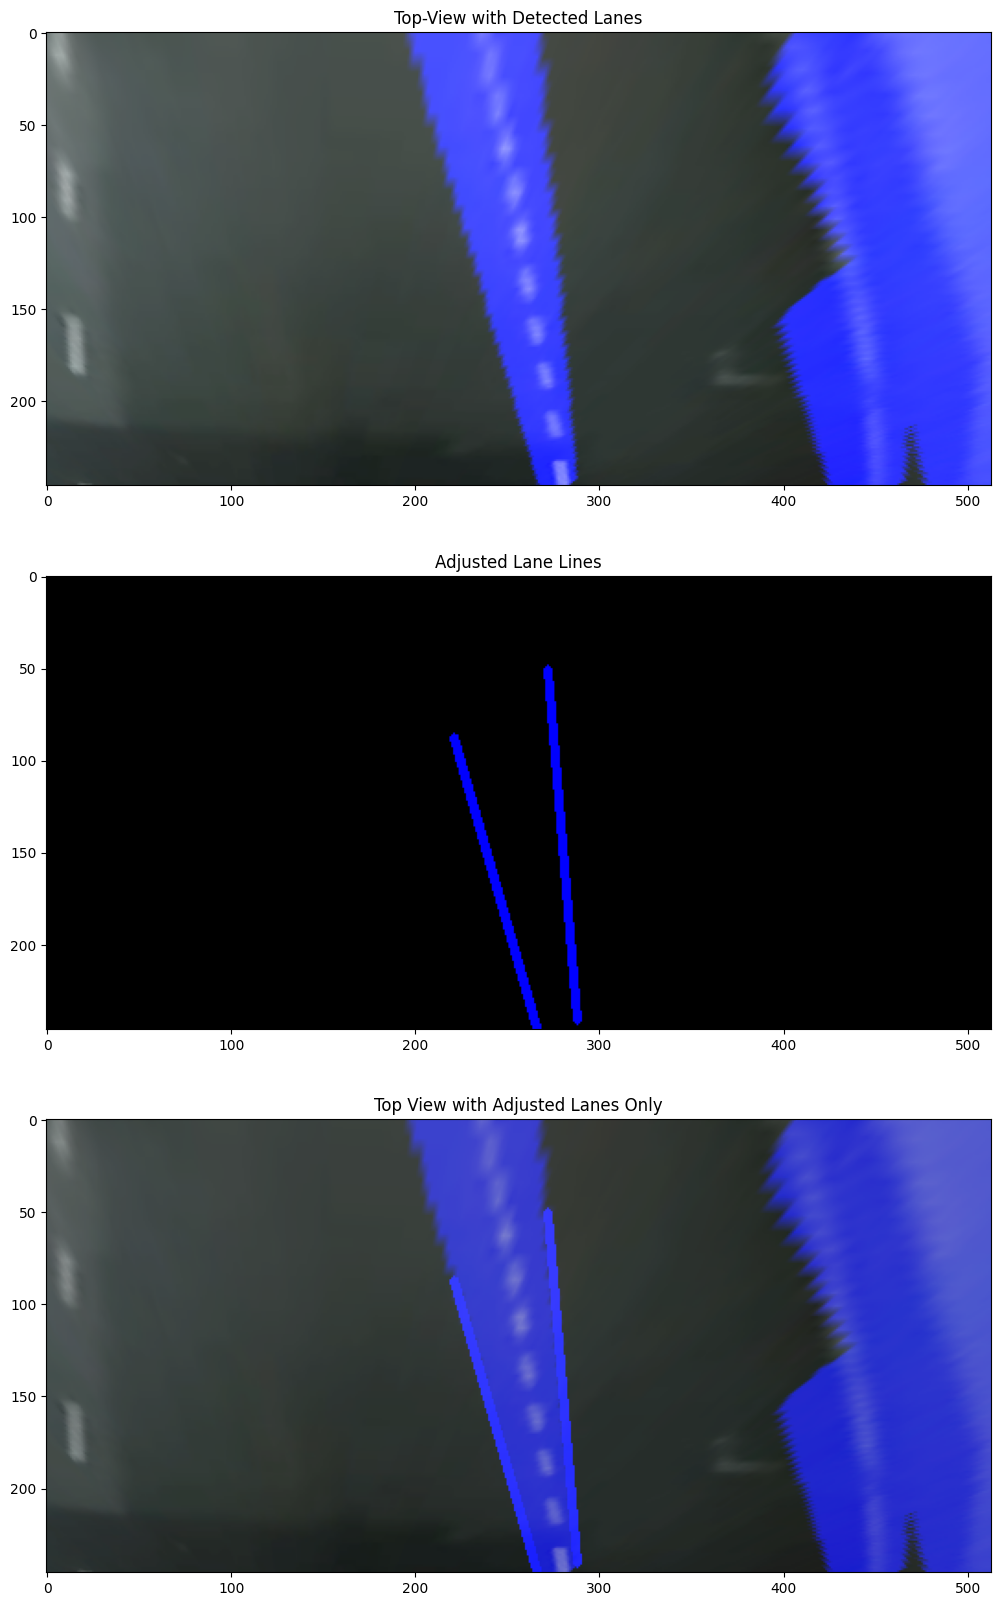

In [2]:
def perspective_transform(image, src_points, scale_width=1, scale_height=3.0):
    original_height, original_width = image.shape[:2]
    new_width = int(original_width * scale_width)
    new_height = int(original_height * scale_height)
    dst_points = np.float32([
        [0, 0],
        [new_width, 0],
        [new_width, new_height],
        [0, new_height]
    ])
    matrix = cv2.getPerspectiveTransform(src_points.astype(np.float32), dst_points)
    warped_full = cv2.warpPerspective(image, matrix, (new_width, new_height))
    
    # Redetect lines to ensure they are straight and consistent
    canny_warped = canny(warped_full)
    lines = cv2.HoughLinesP(canny_warped, 2, np.pi/180, 100, np.array([]), minLineLength=100, maxLineGap=50)
    adjusted_lines_image = np.zeros_like(warped_full)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Normalize line thickness by adjusting endpoints
            normalized_thickness = 3  # Set a fixed thickness
            cv2.line(adjusted_lines_image, (x1, y1), (x2, y2), (255, 0, 0), normalized_thickness)
    else:
        print("No lanes detected after transformation.")
    
    adjusted_lines_only = cv2.addWeighted(warped_full, 0.8, adjusted_lines_image, 1, 1)
    return warped_full, adjusted_lines_image, adjusted_lines_only

# Assuming 'result' is the image with lanes detected
if result is not None:
    points = select_points(result)
    warped_full, adjusted_lines, adjusted_view = perspective_transform(result, points)
    plt.figure(figsize=(15, 20))
    plt.subplot(311)
    plt.title('Top-View with Detected Lanes')
    plt.imshow(cv2.cvtColor(warped_full, cv2.COLOR_BGR2RGB))
    plt.subplot(312)
    plt.title('Adjusted Lane Lines')
    plt.imshow(cv2.cvtColor(adjusted_lines, cv2.COLOR_BGR2RGB))
    plt.subplot(313)
    plt.title('Top View with Adjusted Lanes Only')
    plt.imshow(cv2.cvtColor(adjusted_view, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Lane detection failed, cannot proceed with transformation.")

# Approach 2

## Part 1: Perspective Transformation (Front to Top view)

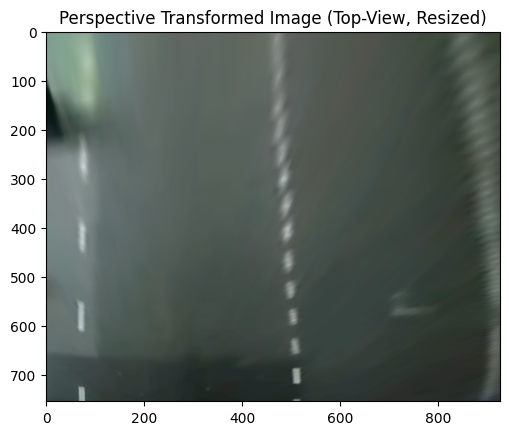

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def select_points(image):
    points = []
    temp_image = image.copy()  # Use a temporary image to show updates without affecting the original image

    def mouse_click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            cv2.circle(temp_image, (x, y), 5, (0, 255, 0), -1)
            points.append((x, y))
            if len(points) > 1:
                # Draw line to the previous point
                cv2.line(temp_image, points[-1], points[-2], (255, 0, 0), 2)
            if len(points) == 4:
                # Complete the region by connecting the last and first point
                cv2.line(temp_image, points[-1], points[0], (255, 0, 0), 2)
            cv2.imshow("Select ROI", temp_image)  # Update the display

    cv2.imshow("Select ROI", temp_image)
    cv2.setMouseCallback("Select ROI", mouse_click)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return np.array(points, dtype=np.float32)

def perspective_transform(image, points):
    # Define the destination points to remap the ROI to the full dimensions of the new image
    dst_height, dst_width = int(image.shape[0] * 2), int(image.shape[1] * 1.25)  # Scale dimensions as required
    dst_points = np.array([
        [0, 0],
        [dst_width, 0],
        [dst_width, dst_height],
        [0, dst_height]
    ], dtype="float32")

    matrix = cv2.getPerspectiveTransform(points, dst_points)
    result = cv2.warpPerspective(image, matrix, (dst_width, dst_height))
    return result

# Load the image
image_path = 'resembler5.jpeg'  # Change to your image path
image = cv2.imread(image_path)
if image is None:
    print("Error: Image not found.")
else:
    selected_points = select_points(image.copy())
    warped_image = perspective_transform(image, selected_points)

    # Display the result
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    plt.title("Perspective Transformed Image (Top-View, Resized)")
    plt.show()


## Part 2: Lane Detection on Top-View Image

/var/folders/z2/fhfxq5f50rv7455rjkv1ppvm0000gn/T/ipykernel_25427/3564955637.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min_x = int(reg.predict([[min_y]]))
/var/folders/z2/fhfxq5f50rv7455rjkv1ppvm0000gn/T/ipykernel_25427/3564955637.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_x = int(reg.predict([[max_y]]))
/var/folders/z2/fhfxq5f50rv7455rjkv1ppvm0000gn/T/ipykernel_25427/3564955637.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min_x = in

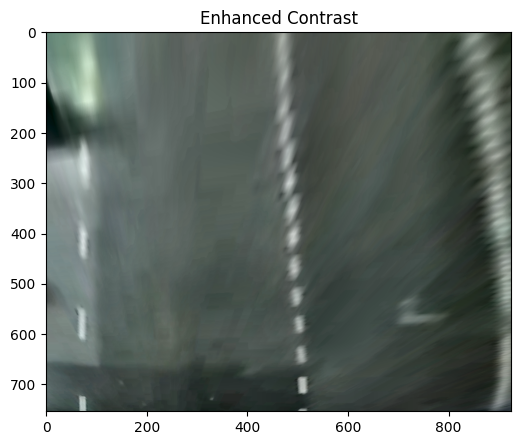

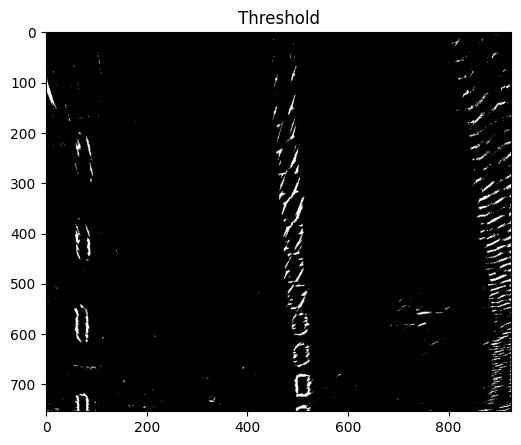

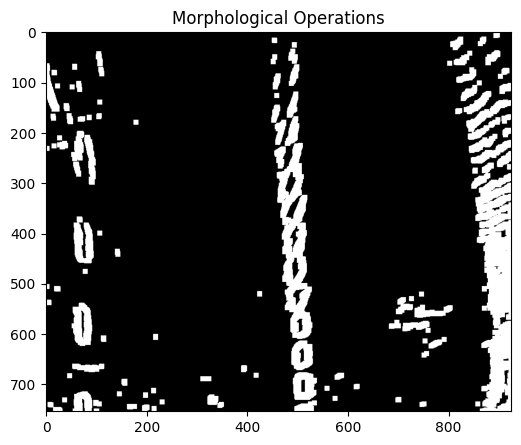

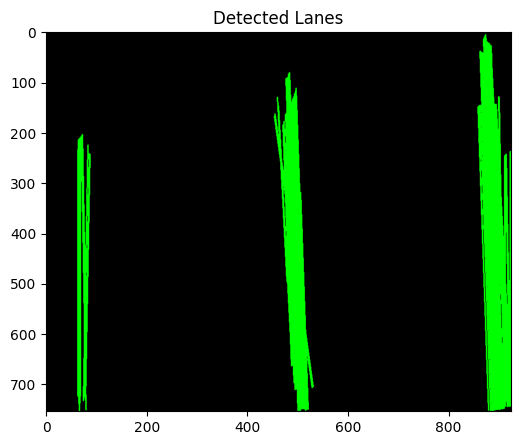

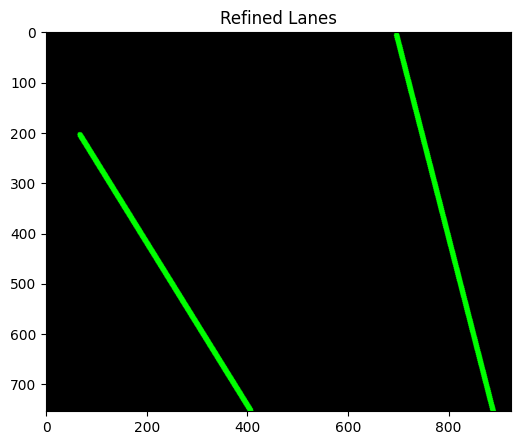

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# Enhance contrast using CLAHE
def enhance_contrast(image, clipLimit=2.0, tileGridSize=(8, 8)):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

# Adaptive thresholding
def adaptive_threshold(image, blockSize=19, C=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, blockSize, C)
    return threshold

# Apply morphological operations
def morphological_operations(image, kernel_size=10):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    dilation = cv2.dilate(closing, kernel, iterations=1)
    return dilation

# Detect lanes using Canny edge detector and Hough transform
def detect_lanes(image, low_threshold=20, high_threshold=80, rho=1, theta=np.pi/180, 
                 threshold=40, min_line_length=150, max_line_gap=200):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    raw_lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), 
                                min_line_length, max_line_gap)
    line_image = np.zeros_like(image)
    filtered_lines = []

    if raw_lines is not None:
        for line in raw_lines:
            for x1, y1, x2, y2 in line:
                # Calculate the slope and filter nearly horizontal lines
                if abs(y2 - y1) > abs(x2 - x1):  # More vertical than horizontal
                    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    filtered_lines.append(line)

    return line_image, filtered_lines


def refine_lanes(line_image, lines):
    if lines is None or len(lines) == 0:
        return line_image

    # Extract endpoints for each line detected
    all_x = []
    all_y = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            all_x.extend([x1, x2])
            all_y.extend([y1, y2])

    # Convert to numpy arrays for clustering
    X = np.array(list(zip(all_x, all_y)))

    # Use KMeans clustering to identify two main lanes
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Create an image to draw the refined lines
    refined_line_image = np.zeros_like(line_image)

    # Fit a line for each cluster using linear regression
    for i in range(2):  # Assuming two main lanes
        cluster_points = X[labels == i]
        if cluster_points.shape[0] > 1:  # Check there are enough points to fit a line
            reg = LinearRegression().fit(cluster_points[:, 1].reshape(-1, 1), cluster_points[:, 0])  # y on x
            min_y = int(min(cluster_points[:, 1]))
            max_y = int(max(cluster_points[:, 1]))
            min_x = int(reg.predict([[min_y]]))
            max_x = int(reg.predict([[max_y]]))
            cv2.line(refined_line_image, (min_x, min_y), (max_x, max_y), (0, 255, 0), 10)

    return refined_line_image

# Main processing function
def process_image_for_lanes(image):
    enhanced = enhance_contrast(image)
    thresholded = adaptive_threshold(enhanced)
    morphed = morphological_operations(thresholded)
    lanes_detected, lines = detect_lanes(enhanced)  # This line was corrected to return both lines and the image

    # Refine lanes to be straight and parallel
    refined_lanes = refine_lanes(lanes_detected, lines)
    
    plt.figure(figsize=(6, 10))
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced Contrast")
    plt.show()
    plt.figure(figsize=(6, 10))
    plt.imshow(thresholded, cmap='gray')
    plt.title("Threshold")
    plt.show()
    plt.figure(figsize=(6, 10))
    plt.imshow(morphed, cmap='gray')
    plt.title("Morphological Operations")
    plt.show()
    plt.figure(figsize=(6, 10))
    plt.imshow(cv2.cvtColor(lanes_detected, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lanes")
    plt.show()
    plt.figure(figsize=(6, 10))
    plt.imshow(cv2.cvtColor(refined_lanes, cv2.COLOR_BGR2RGB))
    plt.title("Refined Lanes")
    plt.show()

    return refined_lanes

# Load the warped image from step 1 (assuming it is stored in 'warped_image')
if 'warped_image' in locals():
    final_result = process_image_for_lanes(warped_image)
else:
    print("Cannot find warped_image from Step 1.")

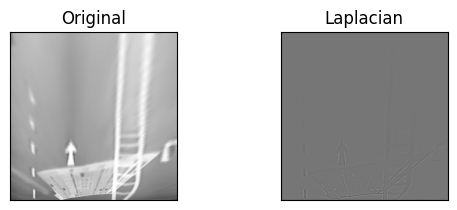

In [3]:
# remove noise
img = cv2.GaussianBlur(img1,(3,3),0)


# convolute with proper kernels
laplacian = cv2.Laplacian(img,cv2.CV_64F)


plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

plt.show()

In [4]:
# Create a custom kernel

# 3x3 array for edge detection
sobel_y = np.array([[ -1, -2, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])

## TODO: Create and apply a Sobel x operator
sobel_x = np.array([[-1,0,1],
                    [ -2, 0 , 2],
                    [ -1,0,1]])

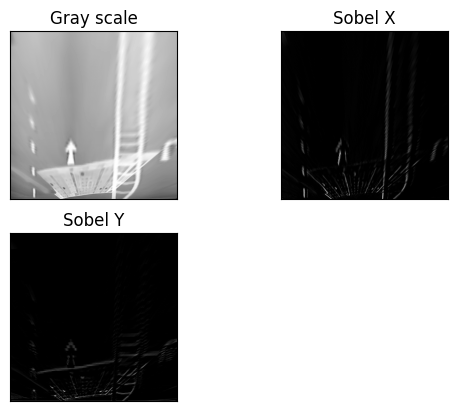

In [5]:
# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
filtered_image_y = cv2.filter2D(img1, -1, sobel_y)
filtered_image_x = cv2.filter2D(img1, -1, sobel_x)

plt.subplot(2,2,1),plt.imshow(img1,cmap = 'gray')
plt.title('Gray scale'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(filtered_image_x,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(filtered_image_y,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

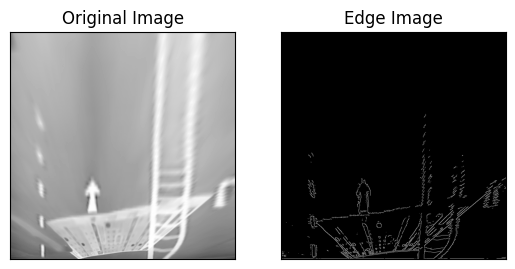

In [9]:
# canny edge detection

edges = cv2.Canny(img,50,50)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([]);